In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import galsim
import pandas as pd

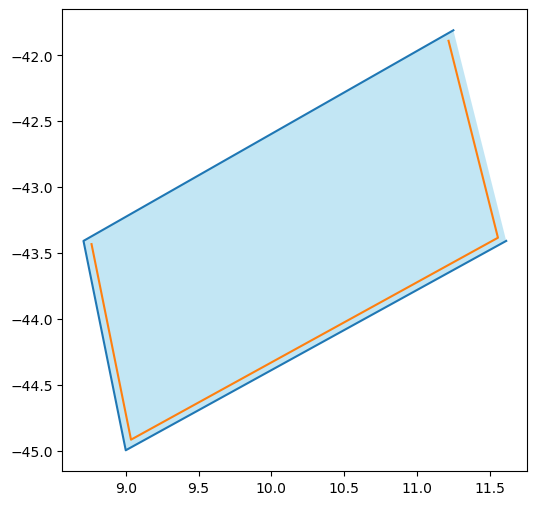

In [2]:
vertices = hp.boundaries(32, 10307, step=1)  # shape (3, n_vertices)
x, y, z = vertices
theta = np.arccos(z)           # polar angle (0=North pole)
phi = np.arctan2(y, x)         # azimuthal angle
ra = np.degrees(phi)            # 0-360 degrees
ra = np.mod(ra, 360)           # ensure within 0-360
dec = 90 - np.degrees(theta) 

dif = 900 * 0.2 /3600

def is_point_in_polygon(ra_poly, dec_poly, px, py):
    vertices = np.array(list(zip(ra_poly, dec_poly)))
    n = len(vertices)
    
    # flatten px, py to work with vectors
    px_flat = px.flatten()
    py_flat = py.flatten()
    inside = np.ones_like(px_flat, dtype=bool)

    for i in range(n):
        A = vertices[i]
        B = vertices[(i+1) % n]
        cross = (B[0] - A[0]) * (py_flat - A[1]) - (B[1] - A[1]) * (px_flat - A[0])
        inside &= (cross >= 0)  # for CCW polygon

    return inside.reshape(px.shape)

def unit(v):
    return v / np.linalg.norm(v)

def offset_polygon_ra_dec(ra, dec, offset):
    # combine ra and dec into vertices
    vertices = np.array(list(zip(ra, dec)))
    n = len(vertices)
    new_edges = []

    # offset each edge inward
    for i in range(n):
        A = vertices[i]
        B = vertices[(i+1) % n]
        edge = B - A

        # inward normal (assumes clockwise polygon)
        normal = np.array([-edge[1], edge[0]])
        normal = unit(normal)

        # offset edge
        A_off = A + normal * offset
        B_off = B + normal * offset
        new_edges.append((A_off, B_off))

    # find intersections of consecutive offset edges
    def intersect(L1, L2):
        p1, p2 = L1
        q1, q2 = L2
        A_mat = np.array([p2 - p1, q1 - q2]).T
        t = np.linalg.solve(A_mat, q1 - p1)[0]
        return p1 + t * (p2 - p1)

    new_vertices = []
    for i in range(n):
        L1 = new_edges[i]
        L2 = new_edges[(i+1) % n]
        new_vertices.append(intersect(L1, L2))

    new_vertices = np.array(new_vertices)
    ra_new = new_vertices[:, 0].tolist()
    dec_new = new_vertices[:, 1].tolist()

    return ra_new, dec_new

ra_new, dec_new = offset_polygon_ra_dec(ra, dec, dif)

# ra_new = [ra[0] - dif, ra[1] + dif, ra[2] + dif, ra[3] - dif]
# dec_new = [dec[0]-dif, dec[1]-dif, dec[2]+dif, dec[3]+dif]

plt.figure(figsize=(6,6))
plt.plot(ra, dec)  # pixel edges
plt.plot(ra_new, dec_new)
plt.fill(ra, dec, 'skyblue', alpha=0.5)


In [6]:
temp = pd.read_parquet('/hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/galaxy_10307.parquet')
print(temp.columns)

Index(['galaxy_id', 'ra', 'dec', 'redshift', 'redshiftHubble',
       'peculiarVelocity', 'shear1', 'shear2', 'convergence',
       'spheroidHalfLightRadiusArcsec', 'diskHalfLightRadiusArcsec',
       'diskEllipticity1', 'diskEllipticity2', 'spheroidEllipticity1',
       'spheroidEllipticity2', 'um_source_galaxy_obs_sm', 'MW_rv', 'MW_av'],
      dtype='object')


In [3]:
theta, phi = hp.pix2ang(32, 10307)
ra_cen = np.degrees(phi)
dec_cen = np.degrees(0.5 * np.pi - theta)

In [5]:
print(ra_cen)
print(dec_cen)

10.161290322580646
-43.40685848593699


In [6]:
span_dec = 1.67
span_ra = span_dec / np.cos(np.deg2rad(dec_cen))
ra = np.linspace(ra_cen-span_ra, ra_cen+span_ra, 67)
dec = np.linspace(dec_cen-span_dec, dec_cen+span_dec, 67)
x1, y1 = np.meshgrid(ra, dec)
print(x1)
theta = np.pi / 2.0 - np.radians(y1)
phi = np.radians(x1)
# in_pix = hp.ang2pix(32, theta, phi)
# print(in_pix)
# yy, xx = np.where(in_pix == 10307)
# xy_points = np.column_stack((ra[xx], dec[yy]))
mask = is_point_in_polygon(ra_new, dec_new, x1, y1)
xy_points = np.column_stack((x1[mask], y1[mask]))
print(len(xy_points))

[[ 7.86257398  7.93223205  8.00189012 ... 12.32069053 12.3903486
  12.46000667]
 [ 7.86257398  7.93223205  8.00189012 ... 12.32069053 12.3903486
  12.46000667]
 [ 7.86257398  7.93223205  8.00189012 ... 12.32069053 12.3903486
  12.46000667]
 ...
 [ 7.86257398  7.93223205  8.00189012 ... 12.32069053 12.3903486
  12.46000667]
 [ 7.86257398  7.93223205  8.00189012 ... 12.32069053 12.3903486
  12.46000667]
 [ 7.86257398  7.93223205  8.00189012 ... 12.32069053 12.3903486
  12.46000667]]
1179


In [158]:
print((2*span_ra*3600 / 67)/0.2)
print((2*span_dec*3600 / 67)/0.2)

1235.1311715007503
897.3134328358209


In [21]:
WORLD_ORIGIN = galsim.CelestialCoord(
    ra=xy_points[1][0] * galsim.degrees,
    dec=xy_points[1][1] * galsim.degrees,
)
wcs = galsim.TanWCS(
        affine=galsim.AffineTransform(
            0.2, 0, 0, 0.2,
            origin=galsim.PositionD(450, 450), # I need to know what Im considering the center, 
        ),                                  # since I use 0,0 as corner when sampling skycat
        world_origin=WORLD_ORIGIN,
        units=galsim.arcsec,
    )
corners = (
            (0, 0),
            (900 , 0),
            (900, 900),
            (0, 900),
        )
vertices = []
for x, y in corners:
    sky_coord = wcs.toWorld(galsim.PositionD(x, y))
    vertices.append([sky_coord.ra / galsim.degrees, sky_coord.dec / galsim.degrees])

vertices1 = np.array(vertices)

In [22]:
WORLD_ORIGIN = galsim.CelestialCoord(
    ra=xy_points[0][0] * galsim.degrees,
    dec=xy_points[0][1] * galsim.degrees,
)
wcs = galsim.TanWCS(
        affine=galsim.AffineTransform(
            0.2, 0, 0, 0.2,
            origin=galsim.PositionD(450, 450), # I need to know what Im considering the center, 
        ),                                  # since I use 0,0 as corner when sampling skycat
        world_origin=WORLD_ORIGIN,
        units=galsim.arcsec,
    )  
corners = (
            (0, 0),
            (900 , 0),
            (900, 900),
            (0, 900),
        )
vertices = []
for x, y in corners:
    sky_coord = wcs.toWorld(galsim.PositionD(x, y))
    vertices.append([sky_coord.ra / galsim.degrees, sky_coord.dec / galsim.degrees])

vertices2 = np.array(vertices)

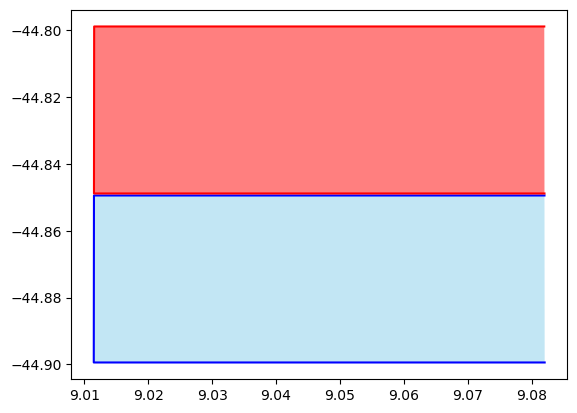

In [23]:
plt.plot(vertices2[:,0], vertices2[:,1], 'b-')  # pixel edges
plt.fill(vertices2[:,0], vertices2[:,1], 'skyblue', alpha=0.5) 
plt.plot(vertices1[:,0], vertices1[:,1], 'r-')  # pixel edges
plt.fill(vertices1[:,0], vertices1[:,1], 'red', alpha=0.5) 

0.8376558201507753


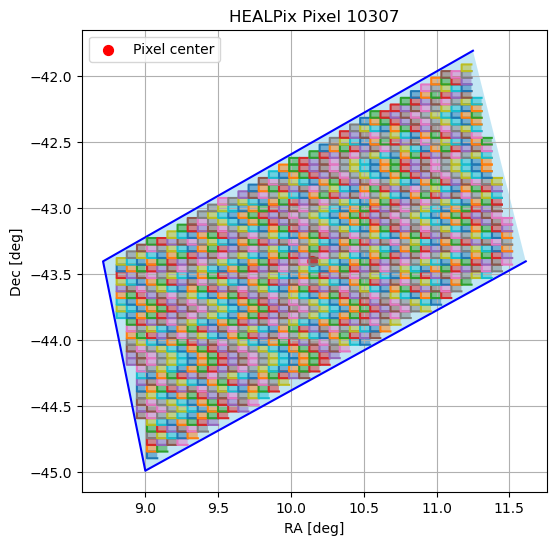

In [24]:
nside = 32
pix = 10307
radius = 900
buffer = 50
vertices = hp.boundaries(nside, pix, step=1)  # shape (3, n_vertices)
x, y, z = vertices
theta = np.arccos(z)           # polar angle (0=North pole)
phi = np.arctan2(y, x)         # azimuthal angle
ra = np.degrees(phi)            # 0-360 degrees
ra = np.mod(ra, 360)           # ensure within 0-360
dec = 90 - np.degrees(theta)   

print(np.cos(np.mean(dec)))


plt.figure(figsize=(6,6))
plt.plot(ra, dec, 'b-')  # pixel edges
plt.fill(ra, dec, 'skyblue', alpha=0.5)  # optional: fill pixel
plt.scatter([np.mean(ra)], [np.mean(dec)], color='red', s=50, label='Pixel center')  # center
# plt.pcolormesh(x1, y1, np.ones((len(x1),len(y1))))
for i in range(len(xy_points)):
    WORLD_ORIGIN = galsim.CelestialCoord(
        ra=xy_points[i][0] * galsim.degrees,
        dec=xy_points[i][1] * galsim.degrees,
    )
    wcs = galsim.TanWCS(
            affine=galsim.AffineTransform(
                0.2, 0, 0, 0.2,
                origin=galsim.PositionD(450, 450), # I need to know what Im considering the center, 
            ),                                  # since I use 0,0 as corner when sampling skycat
            world_origin=WORLD_ORIGIN,
            units=galsim.arcsec,
        )
    corners = (
                (0, 0),
                (900 , 0),
                (900, 900),
                (0, 900),
            )
    vertices = []
    for x, y in corners:
        sky_coord = wcs.toWorld(galsim.PositionD(x, y))
        vertices.append([sky_coord.ra / galsim.degrees, sky_coord.dec / galsim.degrees])

    vertices2 = np.array(vertices)
    plt.plot(vertices2[:,0], vertices2[:,1],)  # pixel edges
    plt.fill(vertices2[:,0], vertices2[:,1], alpha=0.5) 
# plt.plot(vertices1[:,0], vertices1[:,1], 'r-')  # pixel edges
# plt.fill(vertices1[:,0], vertices1[:,1], 'red', alpha=0.5) 
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title(f"HEALPix Pixel {pix}")
plt.legend()
plt.grid(True)
plt.show() 

In [169]:
area = hp.pixelfunc.nside2pixarea(32, True)
print((area * 3600**2/ (0.2**2)) / 500**2)

4350.898256774688


In [16]:
from main import SimCatVal
# from sim import make_sim
temp = {'r': {'psf': 5.245034371101914, 'sigma': 7.9428225},
 'ra': 52.904432001221075,
 'dec': -28.574489795918367,
 'u': {'psf': 6.774187619219095, 'sigma': 19.877594},
 'g': {'psf': 5.623497521468849, 'sigma': 4.0841126},
 'i': {'psf': 4.750795207112166, 'sigma': 8.225676},
 'z': {'psf': 5.468301234694039, 'sigma': 20.028591},
 'y': {'psf': 5.692683780611962, 'sigma': 85.03609}}
_ = temp.pop('ra')
_ = temp.pop('dec')
ra = xy_points[469][0]
dec = xy_points[469][1]
afw_img, cat, truths, area = SimCatVal('/hildafs/home/pladuca/main/skyCatalog.yaml', ra,dec, 90,50, temp, 31.4, True)

# afw_dic, truths = make_sim('/hildafs/home/pladuca/main/skyCatalog.yaml',xy_points[1][0],xy_points[1][1], 900, 'i', 50, 4.800542855802589, 2.286575, 31.4)

2025-12-04 13:43:04,093 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/


Generating Sims


2025-12-04 13:43:04,988 - INFO - Working on healpix pixel 10307
2025-12-04 13:43:10,924 - INFO - Working on healpix pixel 10307


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[10.023427814368258, -43.656564605635474, 101.87382236917988, 'galaxy'], [10.023471218393476, -43.65697869525915, 5.619909428505344, 'galaxy'], [10.02837728598995, -43.66219760099428, 72.75552567892201, 'galaxy'], [10.02099392412925, -43.65665540419503, 119.67774927948058, 'galaxy'], [10.021447540535025, -43.65845005144525, 807.1919329568724, 'galaxy'], [10.027440264200495, -43.6559863220049, 109.07929813159856, 'galaxy'], [10.01905442026433, -43.65671909803585, 212.14084917363323, 'galaxy'], [10.018880054503361, -43.65650724543025, 5.9154926597999795, 'galaxy'], [10.017010291967726, -43.65866115648469, 6.037923550811587, 'galaxy'], [10.016845182003577, -43.65907615830629, 464.68184971587596, 'galaxy'], [10.017203417231332, -43.65936310687654, 18.09162931329053, 'galaxy'], [10.029200216837548, -43.65905160641494, 246.62614813195907, 'galaxy'], [10.028602660110247, -43.65973011131599, 1.137844185275885, 'galaxy'], [10.018722467410912, -43.66064361291618, 633.3767070460996, 'galaxy'], [

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[10.023427814368258, -43.656564605635474, 61.787489329202025, 'galaxy'], [10.023471218393476, -43.65697869525915, 3.436173169749977, 'galaxy'], [10.02837728598995, -43.66219760099428, 45.6513573950417, 'galaxy'], [10.02099392412925, -43.65665540419503, 71.07393217213844, 'galaxy'], [10.021447540535025, -43.65845005144525, 500.86874852209564, 'galaxy'], [10.027440264200495, -43.6559863220049, 65.81112830221382, 'galaxy'], [10.01905442026433, -43.65671909803585, 101.43954134482443, 'galaxy'], [10.018880054503361, -43.65650724543025, 2.952671479675827, 'galaxy'], [10.017010291967726, -43.65866115648469, 2.746758505070048, 'galaxy'], [10.016845182003577, -43.65907615830629, 227.51126075309426, 'galaxy'], [10.017203417231332, -43.65936310687654, 8.386890377306084, 'galaxy'], [10.029200216837548, -43.65905160641494, 105.31586555470525, 'galaxy'], [10.028602660110247, -43.65973011131599, 0.5126010359217137, 'galaxy'], [10.018722467410912, -43.66064361291618, 201.31757693057867, 'galaxy'], [1

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[10.023427814368258, -43.656564605635474, 86.26017125578957, 'galaxy'], [10.023471218393476, -43.65697869525915, 4.794732487850728, 'galaxy'], [10.02837728598995, -43.66219760099428, 63.33832844617565, 'galaxy'], [10.02099392412925, -43.65665540419503, 99.78120358554332, 'galaxy'], [10.021447540535025, -43.65845005144525, 694.1312121206424, 'galaxy'], [10.027440264200495, -43.6559863220049, 91.95459692001438, 'galaxy'], [10.01905442026433, -43.65671909803585, 148.51575825581543, 'galaxy'], [10.018880054503361, -43.65650724543025, 4.278714732120111, 'galaxy'], [10.017010291967726, -43.65866115648469, 4.068905219908762, 'galaxy'], [10.016845182003577, -43.65907615830629, 331.8264076899205, 'galaxy'], [10.017203417231332, -43.65936310687654, 12.37833339397221, 'galaxy'], [10.029200216837548, -43.65905160641494, 158.69707253888174, 'galaxy'], [10.028602660110247, -43.65973011131599, 0.7613287585989147, 'galaxy'], [10.018722467410912, -43.66064361291618, 340.2143721440015, 'galaxy'], [10.0

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[10.023427814368258, -43.656564605635474, 160.78946040027566, 'galaxy'], [10.023471218393476, -43.65697869525915, 8.8546461256256, 'galaxy'], [10.02837728598995, -43.66219760099428, 107.66280834783015, 'galaxy'], [10.02099392412925, -43.65665540419503, 194.55544819317993, 'galaxy'], [10.021447540535025, -43.65845005144525, 1209.9030722351818, 'galaxy'], [10.027440264200495, -43.6559863220049, 175.73286338745584, 'galaxy'], [10.01905442026433, -43.65671909803585, 325.67169677769283, 'galaxy'], [10.018880054503361, -43.65650724543025, 8.688971579772907, 'galaxy'], [10.017010291967726, -43.65866115648469, 8.858468678193228, 'galaxy'], [10.016845182003577, -43.65907615830629, 640.5595840610513, 'galaxy'], [10.017203417231332, -43.65936310687654, 26.138298027443547, 'galaxy'], [10.029200216837548, -43.65905160641494, 385.0214956625842, 'galaxy'], [10.028602660110247, -43.65973011131599, 1.6940728454947231, 'galaxy'], [10.018722467410912, -43.66064361291618, 812.3974831952435, 'galaxy'], [1

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[10.023427814368258, -43.656564605635474, 202.33589006657033, 'galaxy'], [10.023471218393476, -43.65697869525915, 11.008834305228685, 'galaxy'], [10.02837728598995, -43.66219760099428, 135.17371861199942, 'galaxy'], [10.02099392412925, -43.65665540419503, 252.30508789755308, 'galaxy'], [10.021447540535025, -43.65845005144525, 1509.887345860781, 'galaxy'], [10.027440264200495, -43.6559863220049, 218.784814477929, 'galaxy'], [10.01905442026433, -43.65671909803585, 377.46272835972235, 'galaxy'], [10.018880054503361, -43.65650724543025, 10.0395466642089, 'galaxy'], [10.017010291967726, -43.65866115648469, 9.874529553785521, 'galaxy'], [10.016845182003577, -43.65907615830629, 729.7734010224211, 'galaxy'], [10.017203417231332, -43.65936310687654, 29.459886729956203, 'galaxy'], [10.029200216837548, -43.65905160641494, 441.6173069220028, 'galaxy'], [10.028602660110247, -43.65973011131599, 1.905530532767574, 'galaxy'], [10.018722467410912, -43.66064361291618, 802.2345717759378, 'galaxy'], [10.

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[10.023427814368258, -43.656564605635474, 213.88177296484992, 'galaxy'], [10.023471218393476, -43.65697869525915, 11.5147201749555, 'galaxy'], [10.02837728598995, -43.66219760099428, 147.97094519148533, 'galaxy'], [10.02099392412925, -43.65665540419503, 264.9640209133557, 'galaxy'], [10.021447540535025, -43.65845005144525, 1620.8916075218908, 'galaxy'], [10.027440264200495, -43.6559863220049, 200.5399501883797, 'galaxy'], [10.01905442026433, -43.65671909803585, 339.49633866377417, 'galaxy'], [10.018880054503361, -43.65650724543025, 8.723927593455196, 'galaxy'], [10.017010291967726, -43.65866115648469, 9.000330963688414, 'galaxy'], [10.016845182003577, -43.65907615830629, 623.4727672393794, 'galaxy'], [10.017203417231332, -43.65936310687654, 26.348844056758455, 'galaxy'], [10.029200216837548, -43.65905160641494, 416.5662093997254, 'galaxy'], [10.028602660110247, -43.65973011131599, 1.7415756295330067, 'galaxy'], [10.018722467410912, -43.66064361291618, 907.250733825264, 'galaxy'], [10.

  0%|          | 0/6 [00:00<?, ?it/s]

Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(1, 1) < 6]
Reducing approxOrder to 0
Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(1, 1) < 6]
Reducing approxOrder to 0
Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(1, 1) < 6]
Reducing approxOrder to 0
Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(1, 1) < 6]
Reducing approxOrder to 0
Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(1, 1) < 6]
Reducing approxOrder to 0
Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(1, 1) < 6]
Reducing approxOrder to 0


Done!


In [2]:
import pickle
with open('/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_v4/run_20260118T14_1/ECDFS_sim_im.pkl', 'rb') as f:
    test_im = pickle.load(f)
test_im

{'ra': 10.439922607060613,
 'dec': -42.900797879876386,
 'r': {'image': array([[-6.9377452e-01,  6.8946362e-01, -3.1953130e+00, ...,
           7.2738314e-01,  2.3186481e-01, -1.5256786e-01],
         [ 5.9973526e-01, -8.0185592e-01, -1.7711128e+00, ...,
           1.2415668e+00, -2.4503567e+00,  9.9614835e-01],
         [ 2.3845179e+00, -7.2176896e-02,  7.8162998e-01, ...,
           9.2638123e-01, -8.0368090e-01, -1.2766958e+00],
         ...,
         [ 2.5498068e-03,  8.7726569e-01, -1.3157785e+00, ...,
          -1.9762985e+00,  2.3878660e+00, -8.2184339e-01],
         [-2.1453919e+00,  1.0259132e+00,  6.8130332e-01, ...,
          -1.3465496e+00,  1.6104742e+00,  4.2605960e-01],
         [ 1.9892354e+00, -3.3709392e-02,  2.1018345e+00, ...,
           5.2461052e-01, -2.0454011e+00,  1.3414099e+00]], dtype=float32),
  'psf': 2.2133950148732153,
  'sigma': 1.2413118,
  'n_images': 214.0},
 'u': {'image': array([[  5.1192484 ,   5.2238955 ,  -2.338435  , ...,   7.4302683 ,
         

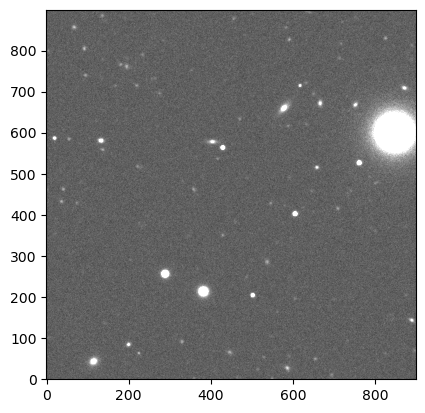

In [3]:
plt.imshow(test_im['y']['image'], origin='lower', cmap='gray', vmin=-150,vmax=250)

In [8]:
from lsst.afw.image import MultibandExposure
from lsst.pipe.tasks.multiBand import DetectCoaddSourcesTask, MeasureMergedCoaddSourcesTask
from lsst.pipe.tasks.mergeDetections import MergeDetectionsTask
from lsst.pipe.tasks.mergeMeasurements import MergeMeasurementsTask
from lsst.pipe.tasks.postprocess import WriteObjectTableTask
from lsst.drp.tasks.forcedPhotCoadd import ForcedPhotCoaddTask
from lsst.meas.extensions.scarlet import ScarletDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import IdFactory
from lsst.pipe.base import Struct
from lsst.afw.table import SourceTable

ref_exp = test_im['i']['image']
bbox = ref_exp.getBBox()
wcs = ref_exp.getWcs()

patchInfo = Struct(outerBBox=bbox, getOuterBBox=lambda: bbox)
skyInfo = Struct(wcs=wcs, patchInfo=patchInfo)

# use single image detect tasks then see how I can merge by hand?
# with the images, and merged sources pass it into the scarlet deblender
# diretly used the Forced measurement task instead of the coadd specific tasks

configDetection = DetectCoaddSourcesTask.ConfigClass()
configMergeDetect = MergeDetectionsTask.ConfigClass()
configMergeDetect.priorityList = ['i','r','g','z','y','u']
configDeblend = ScarletDeblendTask.ConfigClass()

# configMeasurement = MeasureMergedCoaddSourcesTask.ConfigClass()
# configMeasurement.measurement.plugins.names |= [
#     "modelfit_DoubleShapeletPsfApprox",
#     "modelfit_CModel",
#     #"ext_gaap_GaapFlux",
# ]
# configMeasurement.measurement.slots.modelFlux = "modelfit_CModel"
# configMeasurement.measurement.plugins['ext_gaap_GaapFlux'].doMeasure = True
configMeasurement = SingleFrameMeasurementTask.ConfigClass()
configMeasurement.plugins.names |= [
    "modelfit_DoubleShapeletPsfApprox",
    "modelfit_CModel",
    "ext_gaap_GaapFlux",
]
configMeasurement.slots.modelFlux = "modelfit_CModel"

configMergeMeasure = MergeMeasurementsTask.ConfigClass()
configMergeMeasure.priorityList = ['i','r','g','z','y','u']
configForcedPhot = ForcedPhotCoaddTask.ConfigClass()

configWrite = WriteObjectTableTask.ConfigClass()

schema = SourceTable.makeMinimalSchema()
# raerr = schema.addField("coord_raErr", type="F")
# decerr = schema.addField("coord_decErr", type="F")
peakSchema = PeakTable.makeMinimalSchema()

detect = DetectCoaddSourcesTask(schema=schema, config=configDetection)
mergeDetect = MergeDetectionsTask(schema=schema, config=configMergeDetect)
deblend = ScarletDeblendTask(schema=schema, peakSchema=peakSchema, config=configDeblend)

# measure = MeasureMergedCoaddSourcesTask(schema=schema, config=configMeasurement)
# measure.setPrimaryFlags.isSingleFrame = True
measure = SingleFrameMeasurementTask(schema=schema, config=configMeasurement)

mergeMeasure = MergeMeasurementsTask(schema=schema, config=configMergeMeasure)
forcedPhot = ForcedPhotCoaddTask(schema=schema, config=configForcedPhot)
write = WriteObjectTableTask(schema=schema, config=configWrite)

idFactory = IdFactory.makeSimple()
ids = {'u':1, 'g':2,'r':3,'i':4,'z':5,'y':6}
sources = {}
bands = []
exposures = []
for band, exp in exp_dict.items():
    sources[band] = detect.run(exp, idFactory, ids[band]).sources
    bands.append(band)
    exposures.append(exp)
mergedDet = mergeDetect.run(sources, skyInfo=skyInfo, idFactory=idFactory,skySeed=67)
mExposure = MultibandExposure.fromExposures(bands, exposures)
deblended = deblend.run(mExposure, mergedDet)
measurements = {}
for band, exp in exp_dict.items():
    measurements[band] = measure.run(exposure=exp)
mergeMes = mergeMeasure.run(measurements)
forcedResults = {}
for band, exp in exp_dict.items():
    forcedResults[band] = forcedPhot.run(measCat=mergeMes.sources,exposure=exp,refCat=mergeMes.sources,refWcs=exp.getWcs(),exposureId=ids[band])

out = write.run(forcedResults, 0, 0)

print(out)
print(out.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'getBBox'

In [2]:
import numpy as np
import pandas as pd
from afw_utils import create_afw
from utils import get_wcs
import galsim 

class temp_obj:
    def __init__(self, img):
        self.array = img.copy()
    def copy(self):
        return temp_obj(self.array)

img = np.load('test_sim_3000_i_4-800542855802589_2-286575_31-4.npy')
truths = {'i':pd.read_csv('test_truths_3000_i_4-800542855802589_2-286575_31-4.csv')}
wcs = get_wcs(3000,galsim.CelestialCoord(
    ra=10.68 * galsim.degrees,
    dec=-43.67 * galsim.degrees,
))
afw_dic = {'i': create_afw(temp_obj(img), wcs, 'i',4.800542855802589,2.286575,31.4)}


In [ ]:
from afw_utils import COLUMNS
from lsst.meas.algorithms.detection import SourceDetectionTask
# from lsst.meas.algorithms.subtractBackground import SubtractBackgroundTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
import lsst.meas.extensions.gaap
import lsst.meas.modelfit
from lsst.afw.table import SourceTable
import numpy as np

def run_lsst_pipe_single(exp, deblend=True):

    configDetection = SourceDetectionTask.ConfigClass() # all from Tae code
    # # configDetection.thresholdValue = 5
    # # configDetection.doTempLocalBackground = False
    # # configDetection.reEstimateBackground = False

    # configDetection.thresholdValue = 1
    # configDetection.thresholdType = "stdev"  # units for thresholdValue
    # configDetection.doTempLocalBackground = False
    # configDetection.nSigmaToGrow = 1.0
    # configDetection.nSigmaForKernel = 11
    # configDetection.minPixels = 1
    # configDetection.reEstimateBackground = False
    
    if deblend:
        configDeblend = SourceDeblendTask.ConfigClass()
        # configDeblend.propagateAllPeaks = True
    configMeasurement = SingleFrameMeasurementTask.ConfigClass()
    configMeasurement.plugins.names |= [
        "modelfit_DoubleShapeletPsfApprox",
        "modelfit_CModel",
        "ext_gaap_GaapFlux",
    ]
    configMeasurement.slots.modelFlux = "modelfit_CModel"

    # ########
    # configCentroid = configMeasurement.plugins["base_SdssCentroid"]
    # configCentroid.binmax = 32
    # configMeasurement.undeblended["base_SdssCentroid"] = configCentroid

    # configLocalBg = configMeasurement.plugins["base_LocalBackground"]
    # configLocalBg.doMeasure = False
    # configLocalBg.annulusInner = 35
    # configLocalBg.annulusOuter = 50
    # configMeasurement.undeblended["base_LocalBackground"] = configLocalBg

    # configVar = configMeasurement.plugins["base_Variance"]
    # configVar.scale = 1.0
    # configMeasurement.undeblended["base_Variance"] = configVar

    # configHSM = configMeasurement.plugins["ext_shapeHSM_HigherOrderMomentsSource"]
    # configHSM.min_order = 2
    # configHSM.max_order = 5
    # configMeasurement.undeblended["ext_shapeHSM_HigherOrderMomentsSource"] = configHSM

    # configHSMPSF = configMeasurement.plugins["ext_shapeHSM_HigherOrderMomentsPSF"]
    # configHSMPSF.min_order = 2
    # configHSMPSF.max_order = 5
    # configMeasurement.undeblended["ext_shapeHSM_HigherOrderMomentsPSF"] = configHSMPSF

    # configPsfApprox = configMeasurement.plugins["modelfit_DoubleShapeletPsfApprox"]
    # configPsfApprox.innerOrder = 4
    # configPsfApprox.outerOrder = 2
    # configPsfApprox.peakRatio = 0.01
    # configPsfApprox.radiusRatio = 1.5
    # configPsfApprox.maxRadiusBoxFraction = 0.6
    # configPsfApprox.minRadius = 1.0
    # configPsfApprox.optimizer.maxInnerIterations = 100
    # configPsfApprox.optimizer.maxOuterIterations = 250
    # configPsfApprox.optimizer.trustRegionInitialSize = 0.5
    # configPsfApprox.optimizer.trustRegionSolverTolerance = 1e-7
    # configMeasurement.undeblended["modelfit_DoubleShapeletPsfApprox"] = configPsfApprox

    # configCmodel = configMeasurement.plugins["modelfit_CModel"]
    # configCmodel.minInitialRadius *= 3  ##0.1
    # configCmodel.fallbackInitialMomentsPsfFactor = 1.5
    # configCmodel.region.nFitRadiiMin = 0.5
    # configCmodel.region.nFitRadiiMax = 4.0
    # configCmodel.region.nKronRadii = 2.0
    # configCmodel.region.nPsfSigmaMin = 0.5
    # configCmodel.region.nPsfSigmaGrow = 1.0
    # configCmodel.region.maxBadPixelFraction = 0.2
    # configCmodel.region.maxArea *= 25  # 250000

    # for profile in ["initial", "dev", "exp"]:
    #     p = getattr(configCmodel, profile).empiricalPriorConfig
    #     pconf = getattr(configCmodel, profile)
    #     # p.ellipticitySigma = 10. #10.0
    #     # p.logRadiusNu = 50 #50
    #     p.logRadiusMu += np.log(10)  # -4.0
    #     p.logRadiusSigma += np.log(10)  # 1.5

    #     plin = pconf.linearPriorConfig
    #     plin.logRadiusMinOuter += np.log(5)
    #     plin.logRadiusMaxOuter += np.log(5)
    #     plin.logRadiusMinInner += np.log(5)
    #     plin.logRadiusMaxInner += np.log(5)

    #     #pconf.priorSource = "LINEAR"
    #     #pconf.usePixelWeights = True
    #     if profile == "initial":
    #         pconf.profileName = "exp"
    #     elif profile == "dev":
    #         pconf.profileName = "dev"
    #     elif profile == "exp":
    #         pconf.profileName = "exp"

    #     op = getattr(configCmodel, profile).optimizer
    #     op.maxInnerIterations = 200
    #     op.trustRegionGrowFactor = 1.5
    #     op.gradientThreshold = 1e-7
    ############

    schema = SourceTable.makeMinimalSchema()
    raerr = schema.addField("coord_raErr", type="F")
    decerr = schema.addField("coord_decErr", type="F")

    detect = SourceDetectionTask(schema=schema, config=configDetection)
    if deblend:
        deblender = SourceDeblendTask(schema=schema, config=configDeblend)
    #background = SubtractBackgroundTask() ?
    measure = SingleFrameMeasurementTask(schema=schema, config=configMeasurement)

    table = SourceTable.make(schema)
    detect_result = detect.run(table=table, exposure=exp)
    detected_catalog = detect_result.sources
    if deblend:
        deblender.run(exp, detected_catalog)
    measure.run(measCat=detected_catalog, exposure=exp)
    detected_catalog = detected_catalog.copy(True)

    # if deblend:
    #     return detected_catalog.asAstropy()[COLUMNS+['deblend_nChild']]  
    return detected_catalog.asAstropy(), detected_catalog #[COLUMNS]

In [4]:
import numpy as np
from astropy.table import hstack
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky

deblend=True

print('running')

lsst_cat, temp = run_lsst_pipe_single(afw_dic['i'], deblend)

print('piped')

running
piped


In [5]:
# if (deblend == True):
#     primary *= lsst_cat["deblend_nChild"] == 0
cat = lsst_cat[(lsst_cat['deblend_nChild'] == 0) &
    (lsst_cat['base_SdssShape_flag'] == False) &
    (lsst_cat['modelfit_CModel_instFlux'] >= 0) &
    (lsst_cat['modelfit_CModel_flag'] == False) &
    (lsst_cat['ext_gaap_GaapFlux_1_15x_Optimal_instFlux'] >= 0) &
    (lsst_cat['base_SdssCentroid_flag'] == False) &
    (lsst_cat['ext_gaap_GaapFlux_flag'] == False) &
    (lsst_cat['base_ClassificationSizeExtendedness_flag'] == False)]
# cat = cat[(cat['base_PsfFlux_instFlux']/cat['base_PsfFlux_instFluxErr'] >= 10)]

cat['mag'] = -2.5*np.log10(cat['modelfit_CModel_instFlux']) + 31.4
cat['snr'] = cat['modelfit_CModel_instFlux'] / cat['modelfit_CModel_instFluxErr']

ob_coord = SkyCoord(ra=cat['coord_ra'], dec=cat['coord_dec'])
true_coord = SkyCoord(ra=truths['i']['ra'].array*u.degree, dec=truths['i']['dec'].array*u.degree)
idx, d2d, d3d = match_coordinates_sky(ob_coord, true_coord)
max_sep = 0.5 * u.arcsec
sep_constraint = d2d < max_sep
ob_matches = cat[sep_constraint]
truth_matches = truths['i'][truths['i'].index.isin(idx[sep_constraint])]
match = hstack([ob_matches,truth_matches])

print(sum((-2.5*np.log10(truths['i']['flux']) + 31.4) < 25))
print(sum((cat['mag']) < 25))
print(sum(ob_matches['mag'] < 25))

3145
2446
2429


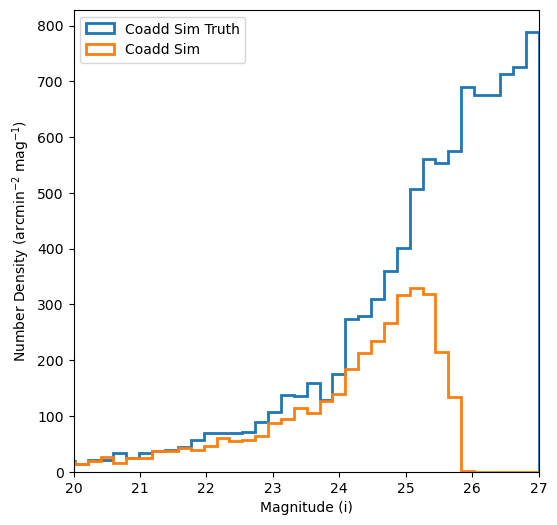

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# dp1 = np.load("/hildafs/home/pladuca/main/dp1_mag.npy")
# dp1_weight = np.load("/hildafs/home/pladuca/main/dp1_weights.npy")
# sim = np.load("/hildafs/home/pladuca/main/sim_mag.npy")
# sim_weight = np.load("/hildafs/home/pladuca/main/sim_weights.npy")
mag = -2.5 * np.log10(cat['modelfit_CModel_instFlux']) + 31.4
snr = (cat['base_PsfFlux_instFlux']/cat['base_PsfFlux_instFluxErr'] > 10)
tmag = -2.5 * np.log10(truths['i']['flux']) + 31.4
mag_bins = np.linspace(17.5, 27, 50)
bin_size = mag_bins[1] - mag_bins[0]
fig, ax = plt.subplots(1,figsize=(6,6))
mag_weight = np.full_like(mag[snr], 1/((3000*0.2/60)**2 *bin_size))
tmag_weight = np.full_like(tmag, 1/((3000*0.2/60)**2 *bin_size))
# mag_full_weight = np.full_like(mags_full, 1/(area_full*bin_size))

mag_bins2 = np.linspace(17.5, 27, 50)
# plt.hist(dp1, mag_bins2,weights=dp1_weight,histtype="step",linewidth=2, label="DP1")
# plt.hist(sim, mag_bins2,weights=sim_weight,histtype="step",linewidth=2, label="OpenUniverse")
# plt.hist(tmag, mag_bins,weights=tmag_weight,histtype="step",linewidth=2,label="Coadd Sim Truth")
# plt.hist(mag[snr], mag_bins,weights=mag_weight,histtype="step",linewidth=2,label="Coadd Sim")
plt.hist(tmag, mag_bins,histtype="step",linewidth=2,label="Coadd Sim Truth")
plt.hist(mag[snr], mag_bins,histtype="step",linewidth=2,label="Coadd Sim")

# plt.hist(mags_full, mag_bins2,weights=mag_full_weight,histtype="step",linewidth=2, label="Full sim")
# plt.yscale('log')
plt.xlabel("Magnitude (i)")
plt.ylabel("Number Density (arcmin$^{-2}$ mag$^{-1}$)")
plt.xlim(20,27)
# plt.ylim(0,23)
plt.legend()

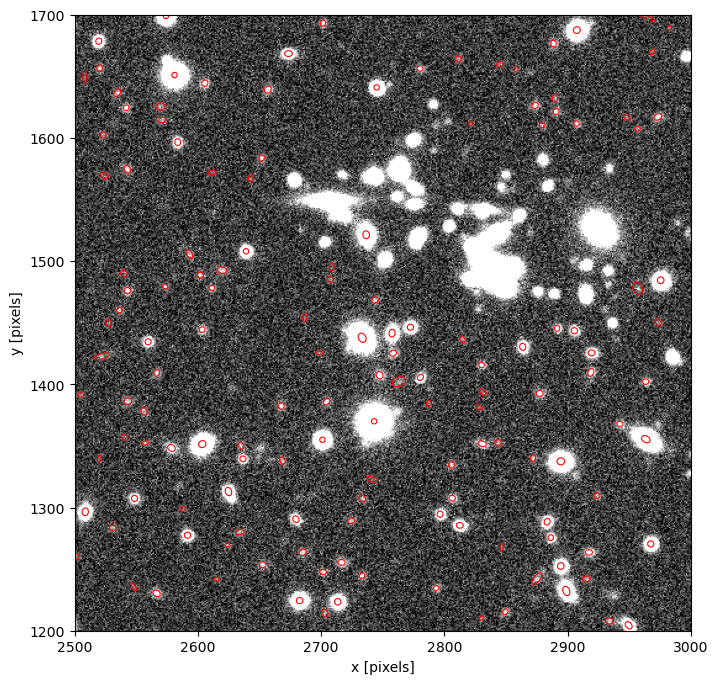

In [7]:
from matplotlib.patches import Ellipse
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, AsinhStretch
#from lsst.geom import SpherePoint, degrees

def plot_sim_image(afw_img, cat=None):
    img = afw_img.image.array
    wcs = afw_img.wcs
    # norm = ImageNormalize(img, interval=MinMaxInterval(), stretch=AsinhStretch(0.0003))
    fig, ax = plt.subplots(figsize=(8,8))
    # ax.imshow(img, origin='lower', cmap='gray', norm=norm) #apply a sinh stretch?
    plt.imshow(afw_img.image.array, origin='lower', cmap='gray', vmin=-3,
           vmax=10)
    if cat != None:
        for i in range(len(cat)):
            # sp = SpherePoint(cat['coord_ra'] * degrees, cat['coord_dec'] * degrees)
            # point = wcs.skyToPixel(sp)
            # x=point.getX()
            # y=point.getY()
            x = cat['base_SdssCentroid_x'][i]
            y = cat['base_SdssCentroid_y'][i]
            xx = cat['base_SdssShape_xx'][i]
            yy = cat['base_SdssShape_yy'][i]
            xy = cat['base_SdssShape_xy'][i]
    
            T = 0.5 * (xx + yy)
            D = np.sqrt(((xx - yy) / 2)**2 + xy**2)
            a = np.sqrt(T + D)
            b = np.sqrt(T - D)
            theta = 0.5 * np.arctan2(2 * xy, xx - yy)
            
            e = Ellipse((x, y), width=2*a, height=2*b,
                        angle=np.degrees(theta), edgecolor='red',
                        facecolor='none', lw=0.8)
            ax.add_patch(e)
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')
    plt.xlim(2500,3000)
    plt.ylim(1200,1700)
    plt.show()

plot_sim_image(afw_dic['i'], cat)

In [7]:
def run_lsst_pipe_single_d(exp, deblend=True):

    configDetection = SourceDetectionTask.ConfigClass()
    
    if deblend:
        configDeblend = SourceDeblendTask.ConfigClass()
    configMeasurement = SingleFrameMeasurementTask.ConfigClass()
    configMeasurement.plugins.names |= [
        "modelfit_DoubleShapeletPsfApprox",
        "modelfit_CModel",
        "ext_gaap_GaapFlux",
    ]
    configMeasurement.slots.modelFlux = "modelfit_CModel"

    schema = SourceTable.makeMinimalSchema()
    raerr = schema.addField("coord_raErr", type="F")
    decerr = schema.addField("coord_decErr", type="F")

    detect = SourceDetectionTask(schema=schema, config=configDetection)
    if deblend:
        deblender = SourceDeblendTask(schema=schema, config=configDeblend)
    #background = SubtractBackgroundTask() ?
    measure = SingleFrameMeasurementTask(schema=schema, config=configMeasurement)

    table = SourceTable.make(schema)
    detect_result = detect.run(table=table, exposure=exp)
    detected_catalog = detect_result.sources
    if deblend:
        deblender.run(exp, detected_catalog)
    measure.run(measCat=detected_catalog, exposure=exp)
    detected_catalog = detected_catalog.copy(True)

    # if deblend:
    #     return detected_catalog.asAstropy()[COLUMNS+['deblend_nChild']]  
    return detected_catalog.asAstropy(), detected_catalog #[COLUMNS]

lsst_cat2, temp = run_lsst_pipe_single_d(afw_dic['i'], deblend)
        
# if (deblend == True):
#     primary *= lsst_cat2["deblend_nChild"] == 0

cat2 = lsst_cat2[(lsst_cat2['deblend_nChild'] == 0) &
    (lsst_cat2['base_SdssShape_flag'] == False) &
    (lsst_cat2['modelfit_CModel_instFlux'] >= 0) &
    (lsst_cat2['modelfit_CModel_flag'] == False) &
    (lsst_cat2['ext_gaap_GaapFlux_1_15x_Optimal_instFlux'] >= 0) &
    (lsst_cat2['base_SdssCentroid_flag'] == False) &
    (lsst_cat2['ext_gaap_GaapFlux_flag'] == False) &
    (lsst_cat2['base_ClassificationSizeExtendedness_flag'] == False)]
cat2 = cat2[(cat2['base_PsfFlux_instFlux']/cat2['base_PsfFlux_instFluxErr'] >= 10)]

cat2['mag'] = -2.5*np.log10(cat2['modelfit_CModel_instFlux']) + 31.4
cat2['snr'] = cat2['modelfit_CModel_instFlux'] / cat2['modelfit_CModel_instFluxErr']

ob_coord = SkyCoord(ra=cat2['coord_ra'], dec=cat2['coord_dec'])
true_coord = SkyCoord(ra=truths['i']['ra'].array*u.degree, dec=truths['i']['dec'].array*u.degree)
idx, d2d, d3d = match_coordinates_sky(ob_coord, true_coord)
max_sep = 0.5 * u.arcsec
sep_constraint = d2d < max_sep
ob_matches = cat2[sep_constraint]
truth_matches = truths['i'][truths['i'].index.isin(idx[sep_constraint])]
match = hstack([ob_matches,truth_matches])

print(sum((-2.5*np.log10(truths['i']['flux']) + 31.4) < 25))
print(sum((cat2['mag']) < 25))
print(sum(ob_matches['mag'] < 25))

3145
2466
2448


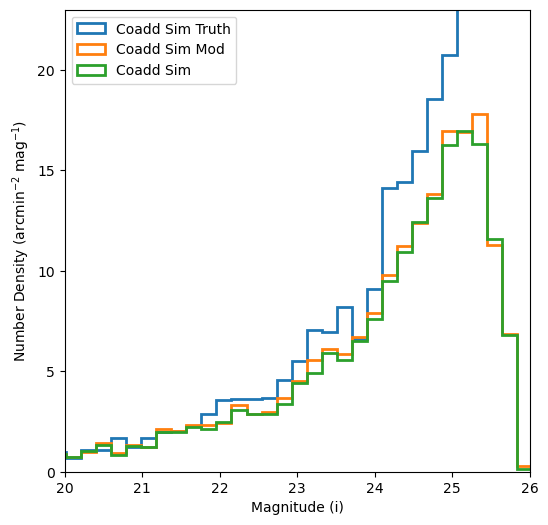

In [15]:
mag2 = -2.5 * np.log10(cat2['modelfit_CModel_instFlux']) + 31.4
snr2 = (cat2['base_PsfFlux_instFlux']/cat2['base_PsfFlux_instFluxErr'] > 10)
fig, ax = plt.subplots(1,figsize=(6,6))
mag2_weight = np.full_like(mag2[snr2], 1/((3000*0.2/60)**2 *bin_size))
# mag_full_weight = np.full_like(mags_full, 1/(area_full*bin_size))

mag_bins2 = np.linspace(17.5, 27, 50)
# plt.hist(dp1, mag_bins2,weights=dp1_weight,histtype="step",linewidth=2, label="DP1")
# plt.hist(sim, mag_bins2,weights=sim_weight,histtype="step",linewidth=2, label="OpenUniverse")
plt.hist(tmag, mag_bins,weights=tmag_weight,histtype="step",linewidth=2,label="Coadd Sim Truth")
plt.hist(mag[snr], mag_bins,weights=mag_weight,histtype="step",linewidth=2,label="Coadd Sim Mod")
plt.hist(mag2[snr2], mag_bins,weights=mag2_weight,histtype="step",linewidth=2,label="Coadd Sim")

# plt.hist(mags_full, mag_bins2,weights=mag_full_weight,histtype="step",linewidth=2, label="Full sim")
# plt.yscale('log')
plt.xlabel("Magnitude (i)")
plt.ylabel("Number Density (arcmin$^{-2}$ mag$^{-1}$)")
plt.xlim(20,26)
plt.ylim(0,23)
plt.legend()

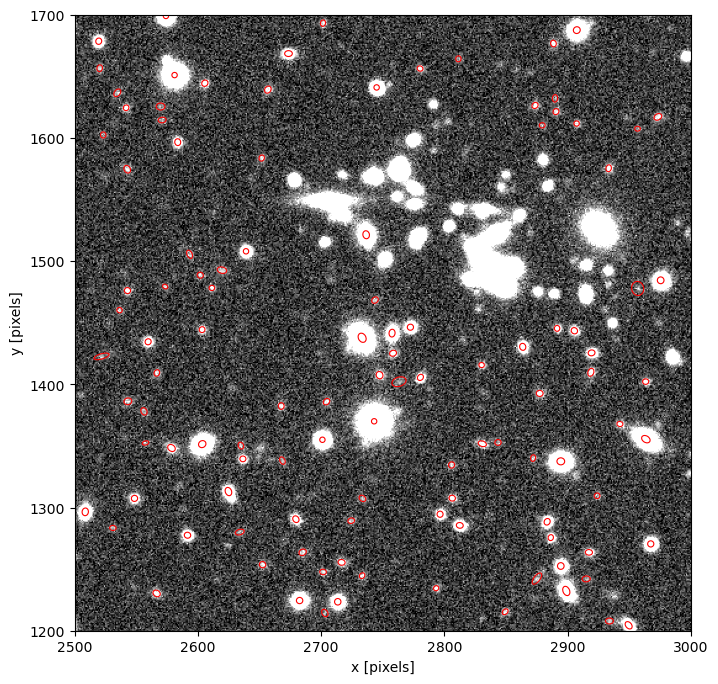

In [10]:
plot_sim_image(afw_dic['i'], cat2)

In [11]:
import galsim
import numpy as np
import healpy as hp
from skycatalogs import skyCatalogs
from skycatalogs.utils import PolygonalRegion
from utils import get_wcs, get_bandpasses, get_noise, get_psf, get_sat_vals
from utils import MJD, WORLD_ORIGIN,convert_flux, get_flux

sky_cat = skyCatalogs.open_catalog('/hildafs/home/pladuca/main/skyCatalog.yaml')
vertices = []
for a, b in zip(ra, dec):
    vertices.append((a, b))
region = PolygonalRegion(vertices)
galaxies = sky_cat.get_object_type_by_region(region, object_type='diffsky_galaxy', mjd=MJD)
bands = get_bandpasses()
fluxes = []
for ob in galaxies:
    flux = get_flux(ob, 'i')#(skycat_obj.get_LSST_flux(band, mjd=MJD))# * exptime * COLLECTING_AREA) #only needed if not setting ZP in bandpass
    flux = convert_flux(flux, bands['i'],31.4)
    fluxes.append(flux)

2025-11-24 16:25:54,515 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/


2025-11-24 16:25:55,677 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10052  intersects region but has no data file for diffsky_galaxy
2025-11-24 16:25:55,680 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10179  intersects region but has no data file for diffsky_galaxy
2025-11-24 16:25:55,681 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10180  intersects region but has no data file for diffsky_galaxy
2025-11-24 16:25:55,681 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10306  intersects region but has no data file for diffsky_galaxy
2025-11-24 16:25:55,682 - INFO - Working on healpix pixel 10307
2025-11-24 16:25:59,613 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10308  intersects region but has no data file for diffsky_galaxy
2025-11-24 16:25:59,619 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10430  intersects region but has no data file for diffsky_galaxy
2025-11-24 16:25:59,622 - WARNING - In SkyCatalog.get_object

In [12]:
mags_full = -2.5*np.log10(np.array(fluxes)) + 31.4
area_full = hp.pixelfunc.nside2pixarea(32, degrees=True) * 60**2

In [16]:
temp_total_area = 4*np.pi * (180/np.pi)**2
num_pix_total = 12 * 4**11 #order
area_ppix = temp_total_area / num_pix_total
print(area_ppix)
print(hp.pixelfunc.nside2pixarea(2**11, degrees=True))

0.0008196227004015302


AttributeError: module 'healpy' has no attribute 'pixelfunc'

In [81]:
print(2909.332737345271/3600)

0.8081479825959087


In [82]:
np.pi* 0.5**2

0.7853981633974483

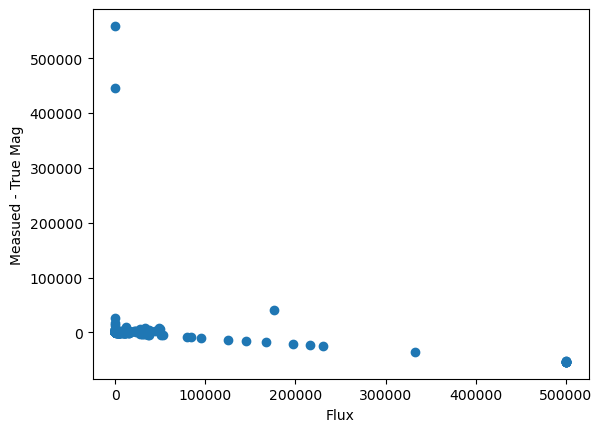

In [34]:
import matplotlib.pyplot as plt
import numpy as np
def compare_matches(matches, coadd_zp):
    mag = matches['mag']
    mag_t = -2.5*np.log10(matches['flux']) + coadd_zp
    dif = (mag - mag_t)
    dif = (matches['modelfit_CModel_instFlux'] - matches['flux'])
    plt.scatter(matches['flux'], dif)
    plt.xlabel('Flux')
    plt.ylabel('Measued - True Mag')
    # plt.yscale('log')
    # plt.ylim(-200,)
    plt.show()
compare_matches(match[0], 30)


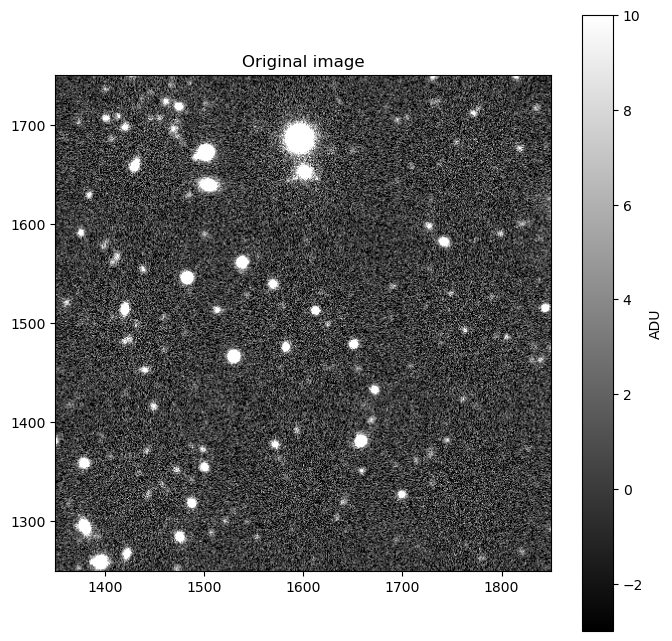

In [9]:
plt.figure(figsize=(8, 8))
# plt.imshow(afw_img[0].image.array, origin='lower', cmap='gray', vmin=np.percentile(afw_img[0].image.array, 5),
#            vmax=np.percentile(afw_img[0].image.array, 95))
plt.imshow(afw_img['i'].image.array, origin='lower', cmap='gray', vmin=-3,
           vmax=10)
# plt.imshow(afw_img[0].image.array, origin='lower', cmap='gray', )
plt.colorbar(label='ADU')
plt.title("Original image")
plt.xlim(1350,1850)
plt.ylim(1250,1750)
plt.show()

In [13]:
from scipy.stats import median_abs_deviation as mad
mad(afw_img['i'].image.array, axis=[0,1],scale='normal')

2.4398949317774314